In [52]:
import nltk
nltk.download('brown') 
# Only the brown corpus is needed in case you don't have it.

# Generate brown corpus text file
with open('brown_corp.txt', 'w+') as f:
    for word in nltk.corpus.brown.words():
        f.write('{word} '.format(word=word))

# Make sure you set FT_HOME to your fastText directory root
FT_HOME = 'fastText/build/'
# download the text8 corpus (a 100 MB sample of cleaned wikipedia text)
import os.path
if not os.path.isfile('text8'):
    !wget -c http://mattmahoney.net/dc/text8.zip
    !unzip text8.zip
# download and preprocess the text9 corpus
if not os.path.isfile('text9'):
  !wget -c http://mattmahoney.net/dc/enwik9.zip
  !unzip enwik9.zip
  !perl {FT_HOME}wikifil.pl enwik9 > text9

[nltk_data] Downloading package brown to /home/jovyan/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [53]:
# Train models
# Make sure Gensim and fasttext properly setup
MODELS_DIR = 'models/'
!mkdir -p {MODELS_DIR}

lr = 0.05
dim = 100
ws = 5
epoch = 5
minCount = 5
neg = 5
loss = 'ns'
t = 1e-4

from gensim.models import Word2Vec
from gensim.models.word2vec import Text8Corpus

# Same values as used for fastText training above
params = {
    'alpha': lr,
    'size': dim,
    'window': ws,
    'iter': epoch,
    'min_count': minCount,
    'sample': t,
    'sg': 1,
    'hs': 0,
    'negative': neg
}

def train_models(corpus_file, output_name):
    output_file = '{:s}_ft'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('Training fasttext on {:s} corpus..'.format(corpus_file))
        %time !{FT_HOME}fasttext skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t}
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    output_file = '{:s}_ft_no_ng'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining fasttext on {:s} corpus (without char n-grams)..'.format(corpus_file))
        %time !{FT_HOME}fasttext skipgram -input {corpus_file} -output {MODELS_DIR+output_file}  -lr {lr} -dim {dim} -ws {ws} -epoch {epoch} -minCount {minCount} -neg {neg} -loss {loss} -t {t} -maxn 0
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))
        
    output_file = '{:s}_gs'.format(output_name)
    if not os.path.isfile(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file))):
        print('\nTraining word2vec on {:s} corpus..'.format(corpus_file))
        
        # Text8Corpus class for reading space-separated words file
        %time gs_model = Word2Vec(Text8Corpus(corpus_file), **params); gs_model
        # Direct local variable lookup doesn't work properly with magic statements (%time)
        locals()['gs_model'].wv.save_word2vec_format(os.path.join(MODELS_DIR, '{:s}.vec'.format(output_file)))
        print('\nSaved gensim model as {:s}.vec'.format(output_file))
    else:
        print('\nUsing existing model file {:s}.vec'.format(output_file))

evaluation_data = {}
train_models('brown_corp.txt', 'brown')


Using existing model file brown_ft.vec

Using existing model file brown_ft_no_ng.vec

Using existing model file brown_gs.vec


In [54]:
train_models(corpus_file='text8', output_name='text8')


Using existing model file text8_ft.vec

Using existing model file text8_ft_no_ng.vec

Using existing model file text8_gs.vec


In [55]:
train_models(corpus_file='text9', output_name='text9')


Using existing model file text9_ft.vec

Using existing model file text9_ft_no_ng.vec

Using existing model file text9_gs.vec


In [23]:
# download the file questions-words.txt to be used for comparing word embeddings
!wget https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt

--2018-05-31 07:02:35--  https://raw.githubusercontent.com/tmikolov/word2vec/master/questions-words.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 603955 (590K) [text/plain]
Saving to: ‘questions-words.txt’

questions-words.txt 100%[===================>] 589.80K  --.-KB/s    in 0.09s   

2018-05-31 07:02:36 (6.64 MB/s) - ‘questions-words.txt’ saved [603955/603955]



In [56]:
import logging
import gensim.models.keyedvectors as word2vec

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Training times in seconds
evaluation_data['brown'] = [(18, 54.3, 32.5)]
evaluation_data['text8'] = [(402, 942, 496)]
evaluation_data['text9'] = [(3218, 6589, 3550)]

def print_accuracy(model, questions_file):
    print('Evaluating...\n')
    acc = model.accuracy(questions_file)

    sem_correct = sum((len(acc[i]['correct']) for i in range(5)))
    sem_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5))
    sem_acc = 100*float(sem_correct)/sem_total
    print('\nSemantic: {:d}/{:d}, Accuracy: {:.2f}%'.format(sem_correct, sem_total, sem_acc))
    
    syn_correct = sum((len(acc[i]['correct']) for i in range(5, len(acc)-1)))
    syn_total = sum((len(acc[i]['correct']) + len(acc[i]['incorrect'])) for i in range(5,len(acc)-1))
    syn_acc = 100*float(syn_correct)/syn_total
    print('Syntactic: {:d}/{:d}, Accuracy: {:.2f}%\n'.format(syn_correct, syn_total, syn_acc))
    return (sem_acc, syn_acc)

word_analogies_file = 'questions-words.txt'
accuracies = []
print('\nLoading Gensim embeddings')
brown_gs = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_gs.vec')
print('Accuracy for Word2Vec:')
accuracies.append(print_accuracy(brown_gs, word_analogies_file))

print('\nLoading FastText embeddings')
brown_ft = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(brown_ft, word_analogies_file))

2018-06-01 01:51:01,084 : INFO : loading projection weights from models/brown_gs.vec



Loading Gensim embeddings


2018-06-01 01:51:02,357 : INFO : loaded (15173, 100) matrix from models/brown_gs.vec
2018-06-01 01:51:02,454 : INFO : precomputing L2-norms of word weight vectors


Accuracy for Word2Vec:
Evaluating...



2018-06-01 01:51:02,660 : INFO : capital-common-countries: 4.4% (4/90)
2018-06-01 01:51:02,735 : INFO : capital-world: 0.0% (0/44)
2018-06-01 01:51:02,760 : INFO : currency: 0.0% (0/12)
2018-06-01 01:51:03,350 : INFO : city-in-state: 1.3% (6/457)
2018-06-01 01:51:03,642 : INFO : family: 16.2% (34/210)
2018-06-01 01:51:04,633 : INFO : gram1-adjective-to-adverb: 0.1% (1/756)
2018-06-01 01:51:04,818 : INFO : gram2-opposite: 0.8% (1/132)
2018-06-01 01:51:06,194 : INFO : gram3-comparative: 3.8% (40/1056)
2018-06-01 01:51:06,474 : INFO : gram4-superlative: 0.5% (1/210)
2018-06-01 01:51:07,328 : INFO : gram5-present-participle: 1.4% (9/650)
2018-06-01 01:51:07,726 : INFO : gram6-nationality-adjective: 1.7% (5/297)
2018-06-01 01:51:09,421 : INFO : gram7-past-tense: 1.0% (13/1260)
2018-06-01 01:51:10,186 : INFO : gram8-plural: 4.5% (25/552)
2018-06-01 01:51:10,839 : INFO : gram9-plural-verbs: 0.9% (3/342)
2018-06-01 01:51:10,845 : INFO : total: 2.3% (142/6068)
2018-06-01 01:51:10,852 : INFO : l


Semantic: 44/813, Accuracy: 5.41%
Syntactic: 98/5255, Accuracy: 1.86%


Loading FastText embeddings


2018-06-01 01:51:12,401 : INFO : loaded (15173, 100) matrix from models/brown_ft.vec
2018-06-01 01:51:12,501 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):
Evaluating...



2018-06-01 01:51:12,713 : INFO : capital-common-countries: 0.0% (0/90)
2018-06-01 01:51:12,815 : INFO : capital-world: 0.0% (0/44)
2018-06-01 01:51:12,845 : INFO : currency: 0.0% (0/12)
2018-06-01 01:51:13,549 : INFO : city-in-state: 1.3% (6/457)
2018-06-01 01:51:13,906 : INFO : family: 16.7% (35/210)
2018-06-01 01:51:15,124 : INFO : gram1-adjective-to-adverb: 64.6% (488/756)
2018-06-01 01:51:15,373 : INFO : gram2-opposite: 81.8% (108/132)
2018-06-01 01:51:17,185 : INFO : gram3-comparative: 61.6% (651/1056)
2018-06-01 01:51:17,529 : INFO : gram4-superlative: 75.7% (159/210)
2018-06-01 01:51:18,554 : INFO : gram5-present-participle: 61.7% (401/650)
2018-06-01 01:51:19,032 : INFO : gram6-nationality-adjective: 31.0% (92/297)
2018-06-01 01:51:21,013 : INFO : gram7-past-tense: 12.4% (156/1260)
2018-06-01 01:51:21,945 : INFO : gram8-plural: 58.3% (322/552)
2018-06-01 01:51:22,489 : INFO : gram9-plural-verbs: 70.5% (241/342)
2018-06-01 01:51:22,493 : INFO : total: 43.8% (2659/6068)



Semantic: 41/813, Accuracy: 5.04%
Syntactic: 2618/5255, Accuracy: 49.82%



In [57]:
print('Loading FastText embeddings')
brown_ft_no_ng = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'brown_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(brown_ft_no_ng, word_analogies_file))
evaluation_data['brown'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

2018-06-01 01:52:30,238 : INFO : loading projection weights from models/brown_ft_no_ng.vec


Loading FastText embeddings


2018-06-01 01:52:31,498 : INFO : loaded (15173, 100) matrix from models/brown_ft_no_ng.vec
2018-06-01 01:52:31,579 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (without n-grams):
Evaluating...



2018-06-01 01:52:32,043 : INFO : capital-common-countries: 3.3% (3/90)
2018-06-01 01:52:32,123 : INFO : capital-world: 0.0% (0/44)
2018-06-01 01:52:32,147 : INFO : currency: 0.0% (0/12)
2018-06-01 01:52:32,782 : INFO : city-in-state: 1.3% (6/457)
2018-06-01 01:52:33,083 : INFO : family: 13.8% (29/210)
2018-06-01 01:52:34,107 : INFO : gram1-adjective-to-adverb: 0.1% (1/756)
2018-06-01 01:52:34,286 : INFO : gram2-opposite: 0.0% (0/132)
2018-06-01 01:52:35,693 : INFO : gram3-comparative: 2.7% (28/1056)
2018-06-01 01:52:36,038 : INFO : gram4-superlative: 0.0% (0/210)
2018-06-01 01:52:36,952 : INFO : gram5-present-participle: 1.7% (11/650)
2018-06-01 01:52:37,377 : INFO : gram6-nationality-adjective: 3.0% (9/297)
2018-06-01 01:52:39,122 : INFO : gram7-past-tense: 2.0% (25/1260)
2018-06-01 01:52:39,883 : INFO : gram8-plural: 7.6% (42/552)
2018-06-01 01:52:40,356 : INFO : gram9-plural-verbs: 3.8% (13/342)
2018-06-01 01:52:40,360 : INFO : total: 2.8% (167/6068)



Semantic: 38/813, Accuracy: 4.67%
Syntactic: 129/5255, Accuracy: 2.45%



In [58]:
accuracies = []
print('Loading Gensim embeddings')
text8_gs = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_gs.vec')
print('Accuracy for word2vec:')
accuracies.append(print_accuracy(text8_gs, word_analogies_file))

print('Loading FastText embeddings (with n-grams)')
text8_ft = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(text8_ft, word_analogies_file))

print('Loading FastText embeddings')
text8_ft_no_ng = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'text8_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(text8_ft_no_ng, word_analogies_file))

evaluation_data['text8'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

2018-06-01 01:54:24,761 : INFO : loading projection weights from models/text8_gs.vec


Loading Gensim embeddings


2018-06-01 01:54:30,879 : INFO : loaded (71290, 100) matrix from models/text8_gs.vec
2018-06-01 01:54:31,292 : INFO : precomputing L2-norms of word weight vectors


Accuracy for word2vec:
Evaluating...



2018-06-01 01:54:33,483 : INFO : capital-common-countries: 66.0% (334/506)
2018-06-01 01:54:37,828 : INFO : capital-world: 43.2% (627/1452)
2018-06-01 01:54:38,611 : INFO : currency: 22.4% (60/268)
2018-06-01 01:54:43,648 : INFO : city-in-state: 22.7% (356/1571)
2018-06-01 01:54:44,588 : INFO : family: 57.2% (175/306)
2018-06-01 01:54:46,905 : INFO : gram1-adjective-to-adverb: 13.5% (102/756)
2018-06-01 01:54:47,816 : INFO : gram2-opposite: 14.1% (43/306)
2018-06-01 01:54:51,650 : INFO : gram3-comparative: 48.8% (615/1260)
2018-06-01 01:54:53,210 : INFO : gram4-superlative: 31.6% (160/506)
2018-06-01 01:54:56,167 : INFO : gram5-present-participle: 27.0% (268/992)
2018-06-01 01:55:00,342 : INFO : gram6-nationality-adjective: 76.7% (1052/1371)
2018-06-01 01:55:04,481 : INFO : gram7-past-tense: 30.3% (404/1332)
2018-06-01 01:55:07,531 : INFO : gram8-plural: 50.7% (503/992)
2018-06-01 01:55:09,638 : INFO : gram9-plural-verbs: 23.2% (151/650)
2018-06-01 01:55:09,643 : INFO : total: 39.5% (4


Semantic: 1552/4103, Accuracy: 37.83%
Syntactic: 3298/8165, Accuracy: 40.39%

Loading FastText embeddings (with n-grams)


2018-06-01 01:55:16,144 : INFO : loaded (71290, 100) matrix from models/text8_ft.vec


Accuracy for FastText (with n-grams):
Evaluating...



2018-06-01 01:55:16,748 : INFO : precomputing L2-norms of word weight vectors
2018-06-01 01:55:18,676 : INFO : capital-common-countries: 59.1% (299/506)
2018-06-01 01:55:23,303 : INFO : capital-world: 39.9% (579/1452)
2018-06-01 01:55:24,246 : INFO : currency: 19.4% (52/268)
2018-06-01 01:55:29,112 : INFO : city-in-state: 17.7% (268/1511)
2018-06-01 01:55:30,124 : INFO : family: 49.7% (152/306)
2018-06-01 01:55:32,837 : INFO : gram1-adjective-to-adverb: 75.0% (567/756)
2018-06-01 01:55:33,922 : INFO : gram2-opposite: 57.2% (175/306)
2018-06-01 01:55:38,230 : INFO : gram3-comparative: 67.9% (855/1260)
2018-06-01 01:55:39,911 : INFO : gram4-superlative: 58.9% (298/506)
2018-06-01 01:55:43,152 : INFO : gram5-present-participle: 58.7% (582/992)
2018-06-01 01:55:47,704 : INFO : gram6-nationality-adjective: 95.5% (1309/1371)
2018-06-01 01:55:51,936 : INFO : gram7-past-tense: 35.2% (469/1332)
2018-06-01 01:55:55,191 : INFO : gram8-plural: 87.7% (870/992)
2018-06-01 01:55:57,332 : INFO : gram9


Semantic: 1350/4043, Accuracy: 33.39%
Syntactic: 5533/8165, Accuracy: 67.76%

Loading FastText embeddings


2018-06-01 01:56:03,572 : INFO : loaded (71290, 100) matrix from models/text8_ft_no_ng.vec
2018-06-01 01:56:03,982 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (without n-grams):
Evaluating...



2018-06-01 01:56:05,964 : INFO : capital-common-countries: 73.7% (373/506)
2018-06-01 01:56:10,567 : INFO : capital-world: 46.3% (672/1452)
2018-06-01 01:56:11,437 : INFO : currency: 22.0% (59/268)
2018-06-01 01:56:16,436 : INFO : city-in-state: 23.8% (360/1511)
2018-06-01 01:56:17,527 : INFO : family: 55.2% (169/306)
2018-06-01 01:56:20,140 : INFO : gram1-adjective-to-adverb: 14.4% (109/756)
2018-06-01 01:56:21,199 : INFO : gram2-opposite: 12.4% (38/306)
2018-06-01 01:56:25,652 : INFO : gram3-comparative: 48.9% (616/1260)
2018-06-01 01:56:27,365 : INFO : gram4-superlative: 26.3% (133/506)
2018-06-01 01:56:30,696 : INFO : gram5-present-participle: 25.0% (248/992)
2018-06-01 01:56:35,367 : INFO : gram6-nationality-adjective: 79.2% (1086/1371)
2018-06-01 01:56:39,975 : INFO : gram7-past-tense: 29.4% (392/1332)
2018-06-01 01:56:43,439 : INFO : gram8-plural: 51.9% (515/992)
2018-06-01 01:56:45,703 : INFO : gram9-plural-verbs: 32.2% (209/650)
2018-06-01 01:56:45,710 : INFO : total: 40.8% (4


Semantic: 1633/4043, Accuracy: 40.39%
Syntactic: 3346/8165, Accuracy: 40.98%



In [59]:
#Larger corpus

accuracies = []
print('Loading Gensim embeddings')
text9_gs = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'text9_gs.vec')
print('Accuracy for word2vec:')
accuracies.append(print_accuracy(text9_gs, word_analogies_file))

print('Loading FastText embeddings (with n-grams)')
text9_ft = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'text9_ft.vec')
print('Accuracy for FastText (with n-grams):')
accuracies.append(print_accuracy(text9_ft, word_analogies_file))

print('Loading FastText embeddings')
text9_ft_no_ng = word2vec.KeyedVectors.load_word2vec_format(MODELS_DIR + 'text9_ft_no_ng.vec')
print('Accuracy for FastText (without n-grams):')
accuracies.append(print_accuracy(text9_ft_no_ng, word_analogies_file))

evaluation_data['text9'] += [[acc[0] for acc in accuracies], [acc[1] for acc in accuracies]]

2018-06-01 02:00:18,954 : INFO : loading projection weights from models/text9_gs.vec


Loading Gensim embeddings


2018-06-01 02:00:37,324 : INFO : loaded (218316, 100) matrix from models/text9_gs.vec
2018-06-01 02:00:37,412 : INFO : precomputing L2-norms of word weight vectors


Accuracy for word2vec:
Evaluating...



2018-06-01 02:00:38,870 : INFO : capital-common-countries: 86.0% (435/506)
2018-06-01 02:00:43,315 : INFO : capital-world: 73.9% (1209/1636)
2018-06-01 02:00:43,843 : INFO : currency: 24.2% (43/178)
2018-06-01 02:00:50,729 : INFO : city-in-state: 42.6% (908/2133)
2018-06-01 02:00:51,979 : INFO : family: 70.5% (268/380)
2018-06-01 02:00:54,470 : INFO : gram1-adjective-to-adverb: 28.7% (233/812)
2018-06-01 02:00:55,541 : INFO : gram2-opposite: 34.8% (119/342)
2018-06-01 02:00:59,565 : INFO : gram3-comparative: 70.1% (883/1260)
2018-06-01 02:01:01,212 : INFO : gram4-superlative: 48.6% (246/506)
2018-06-01 02:01:04,217 : INFO : gram5-present-participle: 48.7% (453/930)
2018-06-01 02:01:08,215 : INFO : gram6-nationality-adjective: 93.5% (1282/1371)
2018-06-01 02:01:12,237 : INFO : gram7-past-tense: 46.8% (624/1332)
2018-06-01 02:01:15,477 : INFO : gram8-plural: 74.0% (781/1056)
2018-06-01 02:01:17,670 : INFO : gram9-plural-verbs: 50.0% (351/702)
2018-06-01 02:01:17,673 : INFO : total: 59.6%


Semantic: 2863/4833, Accuracy: 59.24%
Syntactic: 4972/8311, Accuracy: 59.82%

Loading FastText embeddings (with n-grams)


2018-06-01 02:01:35,453 : INFO : loaded (218316, 100) matrix from models/text9_ft.vec
2018-06-01 02:01:35,721 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (with n-grams):
Evaluating...



2018-06-01 02:01:37,372 : INFO : capital-common-countries: 84.0% (425/506)
2018-06-01 02:01:42,044 : INFO : capital-world: 72.1% (1179/1636)
2018-06-01 02:01:42,651 : INFO : currency: 18.0% (32/178)
2018-06-01 02:01:49,560 : INFO : city-in-state: 38.3% (818/2133)
2018-06-01 02:01:50,772 : INFO : family: 60.5% (230/380)
2018-06-01 02:01:53,288 : INFO : gram1-adjective-to-adverb: 51.4% (417/812)
2018-06-01 02:01:54,355 : INFO : gram2-opposite: 49.1% (168/342)
2018-06-01 02:01:58,417 : INFO : gram3-comparative: 75.3% (949/1260)
2018-06-01 02:01:59,906 : INFO : gram4-superlative: 59.7% (302/506)
2018-06-01 02:02:02,630 : INFO : gram5-present-participle: 54.1% (503/930)
2018-06-01 02:02:06,890 : INFO : gram6-nationality-adjective: 94.3% (1293/1371)
2018-06-01 02:02:11,024 : INFO : gram7-past-tense: 47.7% (636/1332)
2018-06-01 02:02:14,194 : INFO : gram8-plural: 83.9% (886/1056)
2018-06-01 02:02:16,251 : INFO : gram9-plural-verbs: 58.1% (408/702)
2018-06-01 02:02:16,253 : INFO : total: 62.7%


Semantic: 2684/4833, Accuracy: 55.53%
Syntactic: 5562/8311, Accuracy: 66.92%

Loading FastText embeddings


2018-06-01 02:02:34,494 : INFO : loaded (218316, 100) matrix from models/text9_ft_no_ng.vec
2018-06-01 02:02:34,580 : INFO : precomputing L2-norms of word weight vectors


Accuracy for FastText (without n-grams):
Evaluating...



2018-06-01 02:02:36,206 : INFO : capital-common-countries: 86.6% (438/506)
2018-06-01 02:02:41,157 : INFO : capital-world: 74.3% (1215/1636)
2018-06-01 02:02:41,714 : INFO : currency: 20.2% (36/178)
2018-06-01 02:02:48,330 : INFO : city-in-state: 38.0% (811/2133)
2018-06-01 02:02:49,554 : INFO : family: 60.5% (230/380)
2018-06-01 02:02:52,282 : INFO : gram1-adjective-to-adverb: 27.2% (221/812)
2018-06-01 02:02:53,438 : INFO : gram2-opposite: 33.3% (114/342)
2018-06-01 02:02:57,549 : INFO : gram3-comparative: 71.3% (898/1260)
2018-06-01 02:02:59,214 : INFO : gram4-superlative: 56.3% (285/506)
2018-06-01 02:03:02,236 : INFO : gram5-present-participle: 48.1% (447/930)
2018-06-01 02:03:06,672 : INFO : gram6-nationality-adjective: 92.4% (1267/1371)
2018-06-01 02:03:10,838 : INFO : gram7-past-tense: 46.0% (613/1332)
2018-06-01 02:03:14,180 : INFO : gram8-plural: 74.9% (791/1056)
2018-06-01 02:03:16,414 : INFO : gram9-plural-verbs: 46.0% (323/702)
2018-06-01 02:03:16,417 : INFO : total: 58.5%


Semantic: 2730/4833, Accuracy: 56.49%
Syntactic: 4959/8311, Accuracy: 59.67%



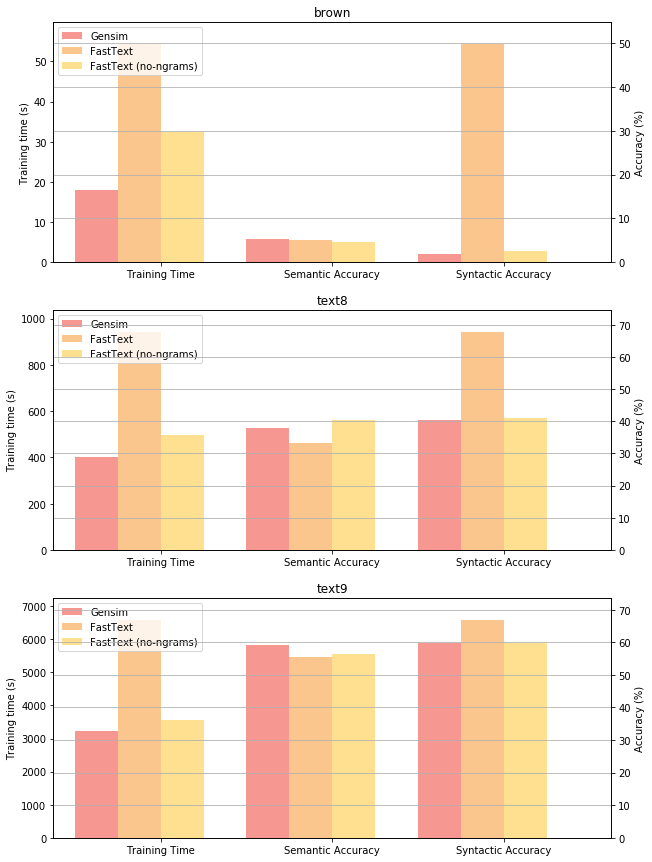

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot(ax, data, corpus_name='brown'):
    width = 0.25
    pos = [(i, i + width, i + 2*width) for i in range(len(data))]
    colors = ['#EE3224', '#F78F1E', '#FFC222']
    acc_ax = ax.twinx()
    # Training time
    ax.bar(pos[0],
            data[0],
            width,
            alpha=0.5,
            color=colors
            )
    # Semantic accuracy
    acc_ax.bar(pos[1],
            data[1],
            width,
            alpha=0.5,
            color=colors
            )

    # Syntactic accuracy
    acc_ax.bar(pos[2],
            data[2],
            width,
            alpha=0.5,
            color=colors
            )

    ax.set_ylabel('Training time (s)')
    acc_ax.set_ylabel('Accuracy (%)')
    ax.set_title(corpus_name)

    acc_ax.set_xticks([p[0] + 1.5 * width for p in pos])
    acc_ax.set_xticklabels(['Training Time', 'Semantic Accuracy', 'Syntactic Accuracy'])

    # Proxy plots for adding legend correctly
    proxies = [ax.bar([0], [0], width=0, color=c, alpha=0.5)[0] for c in colors]
    models = ('Gensim', 'FastText', 'FastText (no-ngrams)')
    ax.legend((proxies), models, loc='upper left')
    
    ax.set_xlim(pos[0][0]-width, pos[-1][0]+width*4)
    ax.set_ylim([0, max(data[0])*1.1] )
    acc_ax.set_ylim([0, max(data[1] + data[2])*1.1] )

    plt.grid()

# Plotting the bars
fig = plt.figure(figsize=(10,15))
for corpus, subplot in zip(sorted(evaluation_data.keys()), [311, 312, 313]):
    ax = fig.add_subplot(subplot)
    plot(ax, evaluation_data[corpus], corpus)

plt.show()